In [66]:
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import lightgbm as lgb

### Loading training datasets, removing extra features and concatenating

In [43]:
results_dir = '../results'

style_csv = 'style_feats_train.csv'
embs_csv = 'alberto_sent_embs_pooled_train.csv'
off_csv = 'offensiveness_train.csv'
uni_bi_csv = 'merged_df_train.xls'

In [44]:
style_df = pd.read_csv(os.path.join(results_dir, style_csv), index_col=0)
embs_df = pd.read_csv(os.path.join(results_dir, embs_csv), index_col=0)
off_df = pd.read_csv(os.path.join(results_dir, off_csv), index_col=0)
uni_bi_df = pd.read_csv(os.path.join(results_dir, uni_bi_csv), index_col=0)

In [45]:
train_y = style_df['hs']
uni_bi_df = uni_bi_df.drop(['text_processed', 'tokenized', 'uppercase_count', 'n_token', 'hs'], axis=1)
style_df = style_df.drop(['hs', 'stereotype', 'raw_text'], axis=1)
off_df = off_df.drop(['offensiveness_score'], axis=1)

In [46]:
style_df = style_df.reset_index(drop=True)
embs_df = embs_df.reset_index(drop=True)
off_df = off_df.reset_index(drop=True)
uni_bi_df = uni_bi_df.reset_index(drop=True)
style_df.shape, embs_df.shape, off_df.shape, uni_bi_df.shape

((6837, 91), (6837, 768), (6837, 1), (6837, 6401))

Creating train sets with stylistic features and without

In [47]:
train_X = pd.concat([style_df, embs_df, off_df, uni_bi_df], axis=1)
train_X.shape

(6837, 7261)

In [48]:
train_X_no_style = pd.concat([embs_df, off_df, uni_bi_df], axis=1)
train_X_no_style.shape

(6837, 7170)

### Loading and fitting the two models on the respective train set

In [49]:
results_dir = '../results'
models_dir = 'models'

lgb_untrained_pkl = 'lgb_untrained.pkl'
lgb_no_style_untrained_pkl = 'lgb_no_style_untrained.pkl'

In [50]:
lgb_untrained = joblib.load(os.path.join(results_dir, models_dir, lgb_untrained_pkl))
lgb_no_style_untrained = joblib.load(os.path.join(results_dir, models_dir, lgb_no_style_untrained_pkl))

In [51]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', lgb_untrained.set_params(verbosity=-1))
], verbose=True)

pipeline_no_style = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', lgb_no_style_untrained.set_params(verbosity=-1))
], verbose=True)

In [52]:
pipeline.fit(train_X, train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   6.6s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 LGBMClassifier(colsample_bytree=0.4, learning_rate=0.05,
                                max_depth=30, min_child_weight=3,
                                n_estimators=280, n_jobs=-1, num_leaves=25,
                                objective='binary', random_state=42,
                                reg_alpha=1.2, reg_lambda=1.2, subsamble=0.7,
                                verbosity=-1))],
         verbose=True)

In [53]:
pipeline_no_style.fit(train_X_no_style, train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   6.8s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 LGBMClassifier(colsample_bytree=0.66, learning_rate=0.05,
                                max_depth=90, min_child_weight=1,
                                n_estimators=286, n_jobs=-1, num_leaves=16,
                                objective='binary', random_state=42,
                                reg_alpha=1, reg_lambda=1, subsample=0.75,
                                verbosity=-1))],
         verbose=True)

### Loading test datasets, removing extra features and concatenating (both for tweets and news, style and no style, for a total of 4 test sets)

In [54]:
results_dir = '../results'

style_test_tweets_csv = 'style_feats_test-tweets.csv'
style_test_news_csv = 'style_feats_test-news.csv'
embs_test_tweets_csv = 'alberto_sent_embs_pooled_test-tweets.csv'
embs_test_news_csv = 'alberto_sent_embs_pooled_test-news.csv'
off_test_tweets_csv = 'offensiveness_test-tweets.csv'
off_test_news_csv = 'offensiveness_test-news.csv'
uni_bi_test_tweets_csv = 'merged_df_test-tweets.xls'
uni_bi_test_news_csv = 'merged_df_test-news.xls'

In [55]:
style_test_tweets_df = pd.read_csv(os.path.join(results_dir, style_test_tweets_csv), index_col=0)
style_test_news_df = pd.read_csv(os.path.join(results_dir, style_test_news_csv), index_col=0)
embs_test_tweets_df = pd.read_csv(os.path.join(results_dir, embs_test_tweets_csv), index_col=0)
embs_test_news_df = pd.read_csv(os.path.join(results_dir, embs_test_news_csv), index_col=0)
off_test_tweets_df = pd.read_csv(os.path.join(results_dir, off_test_tweets_csv), index_col=0)
off_test_news_df = pd.read_csv(os.path.join(results_dir, off_test_news_csv), index_col=0)
uni_bi_test_tweets_df = pd.read_csv(os.path.join(results_dir, uni_bi_test_tweets_csv), index_col=0)
uni_bi_test_news_df = pd.read_csv(os.path.join(results_dir, uni_bi_test_news_csv), index_col=0)

In [56]:
test_y_tweets = style_test_tweets_df['hs']
test_y_news = style_test_news_df['hs']

In [57]:
style_test_tweets_df = style_test_tweets_df.drop(['hs', 'stereotype', 'raw_text'], axis=1)
style_test_news_df = style_test_news_df.drop(['hs', 'stereotype', 'raw_text'], axis=1)

uni_bi_test_tweets_df = uni_bi_test_tweets_df.drop(['text_processed', 'tokenized', 'uppercase_count', 'n_token', 'hs'], axis=1)
uni_bi_test_news_df = uni_bi_test_news_df.drop(['text_processed', 'tokenized', 'uppercase_count', 'n_token', 'hs'], axis=1)

off_test_tweets_df = off_test_tweets_df.drop(['offensiveness_score'], axis=1)
off_test_news_df = off_test_news_df.drop(['offensiveness_score'], axis=1)

In [58]:
style_test_tweets_df = style_test_tweets_df.reset_index(drop=True)
embs_test_tweets_df = embs_test_tweets_df.reset_index(drop=True)
off_test_tweets_df = off_test_tweets_df.reset_index(drop=True)
uni_bi_test_tweets_df = uni_bi_test_tweets_df.reset_index(drop=True)
style_test_tweets_df.shape, embs_test_tweets_df.shape, off_test_tweets_df.shape, uni_bi_test_tweets_df.shape

((1263, 91), (1263, 768), (1263, 1), (1263, 6401))

In [59]:
test_X_tweets = pd.concat([style_test_tweets_df, embs_test_tweets_df, off_test_tweets_df, uni_bi_test_tweets_df], axis=1)
test_X_tweets.shape

(1263, 7261)

In [60]:
test_X_tweets_no_style = pd.concat([embs_test_tweets_df, off_test_tweets_df, uni_bi_test_tweets_df], axis=1)
test_X_tweets_no_style.shape

(1263, 7170)

In [62]:
style_test_news_df = style_test_news_df.reset_index(drop=True)
embs_test_news_df = embs_test_news_df.reset_index(drop=True)
off_test_news_df = off_test_news_df.reset_index(drop=True)
uni_bi_test_news_df = uni_bi_test_news_df.reset_index(drop=True)
style_test_news_df.shape, embs_test_news_df.shape, off_test_news_df.shape, uni_bi_test_news_df.shape

((500, 91), (500, 768), (500, 1), (500, 6401))

In [63]:
test_X_news = pd.concat([style_test_news_df, embs_test_news_df, off_test_news_df, uni_bi_test_news_df], axis=1)
test_X_news.shape

(500, 7261)

In [64]:
test_X_news_no_style = pd.concat([embs_test_news_df, off_test_news_df, uni_bi_test_news_df], axis=1)
test_X_news_no_style.shape

(500, 7170)

## Tests

Pipeline trained on all features, tested on tweets

Classification Report:
              precision    recall  f1-score   support

           0     0.7782    0.7005    0.7373       641
           1     0.7201    0.7942    0.7554       622

    accuracy                         0.7466      1263
   macro avg     0.7491    0.7473    0.7463      1263
weighted avg     0.7496    0.7466    0.7462      1263



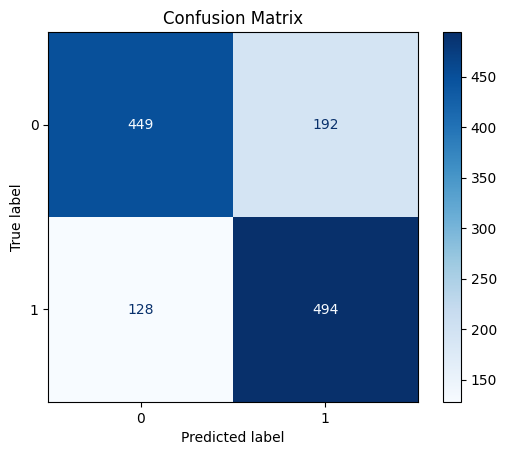

In [78]:
y_pred_tweets = pipeline.predict(test_X_tweets)

print("Classification Report:")
print(classification_report(test_y_tweets, y_pred_tweets, digits=4))

cm = confusion_matrix(test_y_tweets, y_pred_tweets)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Pipeline trained on all features, tested on news

Classification Report:
              precision    recall  f1-score   support

           0     0.7262    0.9561    0.8254       319
           1     0.8250    0.3646    0.5057       181

    accuracy                         0.7420       500
   macro avg     0.7756    0.6604    0.6656       500
weighted avg     0.7620    0.7420    0.7097       500



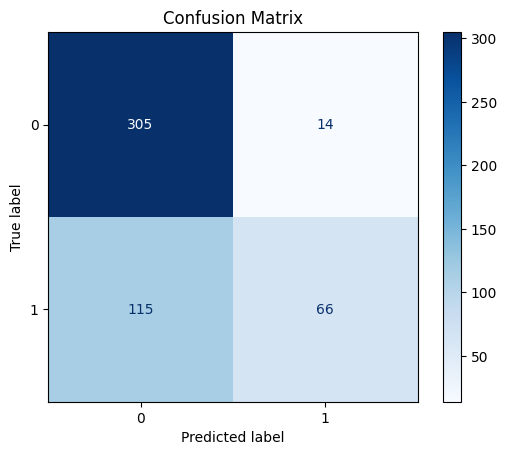

In [79]:
y_pred_news = pipeline.predict(test_X_news)

print("Classification Report:")
print(classification_report(test_y_news, y_pred_news, digits=4))

cm = confusion_matrix(test_y_news, y_pred_news)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Pipeline trained without stylistic features, tested on tweets

Classification Report:
              precision    recall  f1-score   support

           0     0.7551    0.6927    0.7225       641
           1     0.7081    0.7685    0.7371       622

    accuracy                         0.7300      1263
   macro avg     0.7316    0.7306    0.7298      1263
weighted avg     0.7320    0.7300    0.7297      1263



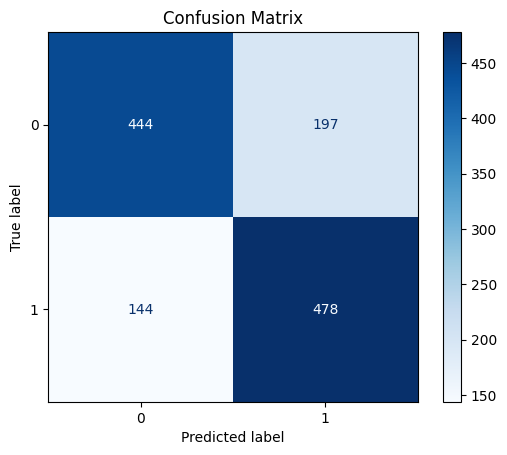

In [80]:
y_pred_tweets_no_style = pipeline_no_style.predict(test_X_tweets_no_style)

print("Classification Report:")
print(classification_report(test_y_tweets, y_pred_tweets_no_style, digits=4))

cm = confusion_matrix(test_y_tweets, y_pred_tweets_no_style)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_no_style.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Pipeline trained without stylistic features, tested on news

Classification Report:
              precision    recall  f1-score   support

           0     0.7281    0.9655    0.8302       319
           1     0.8571    0.3646    0.5116       181

    accuracy                         0.7480       500
   macro avg     0.7926    0.6651    0.6709       500
weighted avg     0.7748    0.7480    0.7149       500



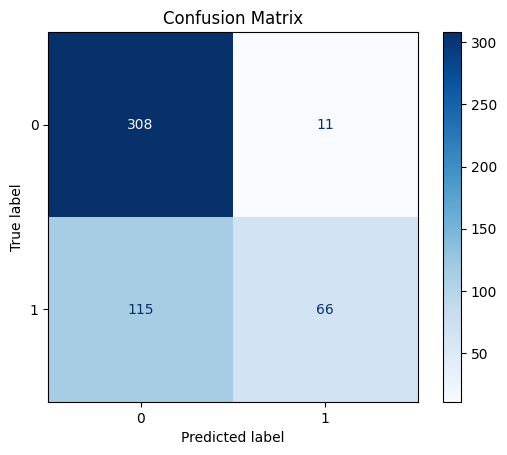

In [81]:
y_pred_news_no_style = pipeline_no_style.predict(test_X_news_no_style)

print("Classification Report:")
print(classification_report(test_y_news, y_pred_news_no_style, digits=4))

cm = confusion_matrix(test_y_news, y_pred_news_no_style)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_no_style.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()